# ML Model Training & Evaluation for Inventory Demand Forecasting

This notebook trains and evaluates machine learning models for demand forecasting using actual sales data from the database.

## 1. Import Required Libraries

In [2]:
import os
import sys
import django
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure Django
sys.path.insert(0, '/workspaces/Intelligent-Inventory-Management-System')
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'config.settings')
django.setup()

from django.utils import timezone
from inventory.models import Product, SalesRecord, DemandForecast, ModelEvaluation

# ML Libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import sklearn
import joblib
import json

print('✓ All libraries imported successfully')
print(f'Django version: {django.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')

✓ All libraries imported successfully
Django version: 4.2.8
Scikit-learn version: 1.3.2


## 2. Load Data from Database

In [5]:
# Allow async operations in notebook environment
os.environ['DJANGO_ALLOW_ASYNC_UNSAFE'] = 'true'

# Load all sales records
sales_records = list(SalesRecord.objects.all().values(
    'id', 'product_id', 'product__name', 'quantity_sold', 'sale_date'
))

df = pd.DataFrame(sales_records)
df['sale_date'] = pd.to_datetime(df['sale_date'])
df = df.sort_values('sale_date')

print(f'Loaded {len(df)} sales records')
print(f'\nDate range: {df["sale_date"].min()} to {df["sale_date"].max()}')
print(f'\nDataset shape: {df.shape}')

Loaded 373 sales records

Date range: 2025-08-08 00:00:00 to 2026-02-04 00:00:00

Dataset shape: (373, 5)


## 3. Explore and Prepare Data

In [6]:
# Basic statistics
print('=== Data Overview ===')
print(f'Total records: {len(df)}')
print(f'Unique products: {df["product_id"].nunique()}')
print(f'\nSales statistics:')
print(df['quantity_sold'].describe())

print(f'\nMissing values:')
print(df.isnull().sum())

print(f'\nTop 10 selling products:')
top_products = df.groupby('product__name')['quantity_sold'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False).head(10)
print(top_products)

=== Data Overview ===
Total records: 373
Unique products: 15

Sales statistics:
count    373.000000
mean       8.895442
std        7.363621
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       30.000000
Name: quantity_sold, dtype: float64

Missing values:
id               0
product_id       0
product__name    0
quantity_sold    0
sale_date        0
dtype: int64

Top 10 selling products:
                     sum       mean  count
product__name                             
Pen Set (50 pcs)     519  18.535714     28
Notebook A4 (Pack)   500  17.857143     28
USB-C Cable          464  18.560000     25
Screen Protector     415  18.863636     22
Wireless Mouse       208   8.000000     26
USB Hub              180   6.666667     27
HDMI Cable           177   6.807692     26
Mouse Pad            124   4.428571     28
Mechanical Keyboard  122   5.304348     23
Webcam HD            115   3.709677     31


## 4. Feature Engineering for Each Product

In [7]:
# Create features for each product
product_features = []

for product_id in df['product_id'].unique():
    product_data = df[df['product_id'] == product_id].sort_values('sale_date')
    product_name = product_data['product__name'].iloc[0]
    
    # Skip products with very few sales
    if len(product_data) < 5:
        continue
    
    sales = product_data['quantity_sold'].values
    
    # Calculate features
    features = {
        'product_id': product_id,
        'product_name': product_name,
        'total_sales': sales.sum(),
        'avg_daily_sales': sales.mean(),
        'max_daily_sales': sales.max(),
        'min_daily_sales': sales.min(),
        'std_daily_sales': sales.std(),
        'num_transactions': len(sales),
        'days_span': (product_data['sale_date'].max() - product_data['sale_date'].min()).days,
    }
    
    # Add rolling averages
    features['ma_7_day'] = product_data['quantity_sold'].rolling(window=7, min_periods=1).mean().iloc[-1]
    features['ma_14_day'] = product_data['quantity_sold'].rolling(window=14, min_periods=1).mean().iloc[-1]
    
    # Sales trend (recent vs older)
    mid = len(sales) // 2
    features['trend'] = (sales[mid:].mean() - sales[:mid].mean()) / (sales[:mid].mean() + 1e-6)
    
    product_features.append(features)

features_df = pd.DataFrame(product_features)
print(f'Created features for {len(features_df)} products')
print(f'\nFeature columns: {list(features_df.columns)}')
print(f'\nSample features:')
print(features_df.head())

Created features for 15 products

Feature columns: ['product_id', 'product_name', 'total_sales', 'avg_daily_sales', 'max_daily_sales', 'min_daily_sales', 'std_daily_sales', 'num_transactions', 'days_span', 'ma_7_day', 'ma_14_day', 'trend']

Sample features:
   product_id        product_name  total_sales  avg_daily_sales  \
0          23    Pen Set (50 pcs)          519        18.535714   
1          20           Desk Lamp           83         3.772727   
2          22  Notebook A4 (Pack)          500        17.857143   
3          19       Monitor Stand          111         4.625000   
4          21           Webcam HD          115         3.709677   

   max_daily_sales  min_daily_sales  std_daily_sales  num_transactions  \
0               30                6         7.957396                28   
1                7                1         1.998450                22   
2               30                7         6.583064                28   
3                8                1        

## 5. Prepare Data for Model Training

In [8]:
# Target: average daily sales (what models will predict)
X = features_df[[
    'total_sales', 'max_daily_sales', 'min_daily_sales', 'std_daily_sales',
    'num_transactions', 'days_span', 'ma_7_day', 'ma_14_day', 'trend'
]].fillna(0)

y = features_df['avg_daily_sales']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nFeature statistics:')
print(X.describe())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'\nTrain set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('✓ Data prepared and scaled')

Features shape: (15, 9)
Target shape: (15,)

Feature statistics:
       total_sales  max_daily_sales  min_daily_sales  std_daily_sales  \
count    15.000000        15.000000        15.000000        15.000000   
mean    221.200000        15.066667         3.000000         3.730226   
std     163.278115         9.338604         3.070598         1.954014   
min      80.000000         7.000000         1.000000         1.998450   
25%     111.500000         8.000000         1.000000         2.233221   
50%     124.000000        12.000000         1.000000         2.922318   
75%     311.500000        21.500000         4.000000         4.740246   
max     519.000000        30.000000         9.000000         7.957396   

       num_transactions   days_span   ma_7_day  ma_14_day      trend  
count         15.000000   15.000000  15.000000  15.000000  15.000000  
mean          24.866667  168.000000   9.209524   8.976190   0.019561  
std            3.563038    9.133924   7.078252   6.412603   0.23

## 6. Train Multiple Models

In [9]:
# Dictionary to store models and results
models = {}
results = {}

print('Training models...\n')

# 1. Linear Regression
print('1. Linear Regression')
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

models['Linear Regression'] = lr_model
results['Linear Regression'] = {
    'MAE': lr_mae,
    'RMSE': lr_rmse,
    'R²': lr_r2,
    'predictions': y_pred_lr
}

print(f'   MAE: {lr_mae:.4f}')
print(f'   RMSE: {lr_rmse:.4f}')
print(f'   R²: {lr_r2:.4f}\n')

# 2. Random Forest
print('2. Random Forest')
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

models['Random Forest'] = rf_model
results['Random Forest'] = {
    'MAE': rf_mae,
    'RMSE': rf_rmse,
    'R²': rf_r2,
    'predictions': y_pred_rf
}

print(f'   MAE: {rf_mae:.4f}')
print(f'   RMSE: {rf_rmse:.4f}')
print(f'   R²: {rf_r2:.4f}\n')

# 3. Gradient Boosting
print('3. Gradient Boosting')
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)

models['Gradient Boosting'] = gb_model
results['Gradient Boosting'] = {
    'MAE': gb_mae,
    'RMSE': gb_rmse,
    'R²': gb_r2,
    'predictions': y_pred_gb
}

print(f'   MAE: {gb_mae:.4f}')
print(f'   RMSE: {gb_rmse:.4f}')
print(f'   R²: {gb_r2:.4f}\n')

print('✓ All models trained')

Training models...

1. Linear Regression
   MAE: 0.6088
   RMSE: 0.6612
   R²: 0.9903

2. Random Forest
   MAE: 1.4462
   RMSE: 1.7195
   R²: 0.9347

3. Gradient Boosting
   MAE: 0.6142
   RMSE: 0.6167
   R²: 0.9916

✓ All models trained


## 7. Model Comparison & Selection

In [11]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R²'] for m in results.keys()]
})

print('\n=== MODEL PERFORMANCE COMPARISON ===')
print(comparison_df.to_string(index=False))

# Select best model (lowest MAE)
best_model_name = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
best_mae = comparison_df['MAE'].min()

print(f'\n🏆 BEST MODEL: {best_model_name}')
print(f'   MAE: {best_mae:.4f}')
print(f'   RMSE: {comparison_df[comparison_df["Model"] == best_model_name]["RMSE"].values[0]:.4f}')
print(f'   R²: {comparison_df[comparison_df["Model"] == best_model_name]["R²"].values[0]:.4f}')

best_model = models[best_model_name]


=== MODEL PERFORMANCE COMPARISON ===
            Model      MAE     RMSE       R²
Linear Regression 0.608801 0.661249 0.990343
    Random Forest 1.446236 1.719515 0.934696
Gradient Boosting 0.614242 0.616716 0.991600

🏆 BEST MODEL: Linear Regression
   MAE: 0.6088
   RMSE: 0.6612
   R²: 0.9903


## 8. Visualize Model Performance

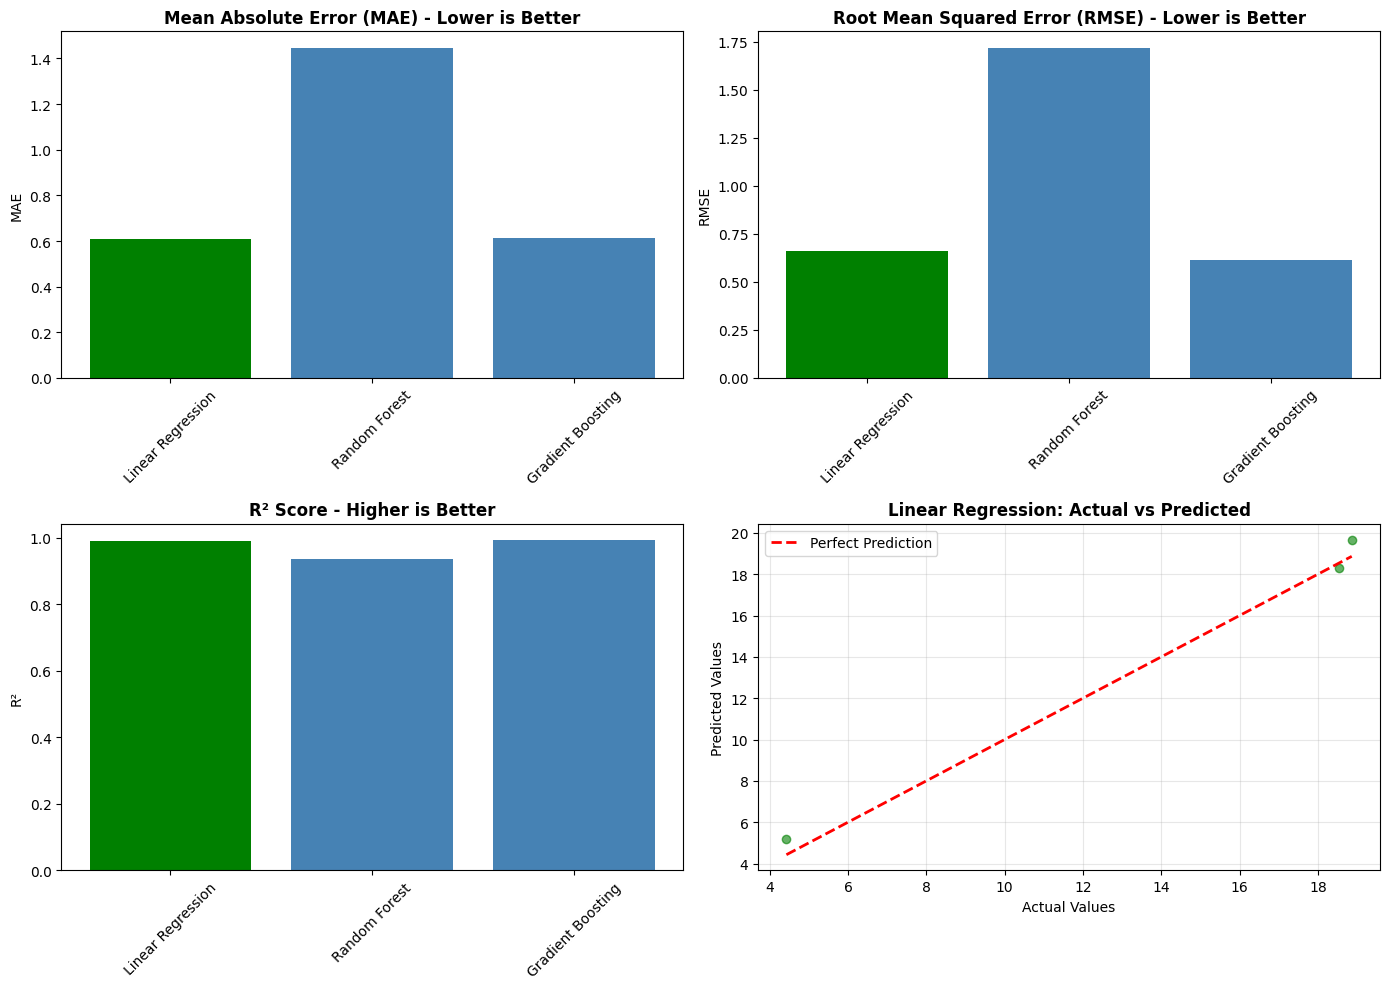

✓ Visualizations complete


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MAE Comparison
ax1 = axes[0, 0]
colors = ['green' if m == best_model_name else 'steelblue' for m in comparison_df['Model']]
ax1.bar(comparison_df['Model'], comparison_df['MAE'], color=colors)
ax1.set_title('Mean Absolute Error (MAE) - Lower is Better', fontsize=12, fontweight='bold')
ax1.set_ylabel('MAE')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: RMSE Comparison
ax2 = axes[0, 1]
ax2.bar(comparison_df['Model'], comparison_df['RMSE'], color=colors)
ax2.set_title('Root Mean Squared Error (RMSE) - Lower is Better', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: R² Comparison
ax3 = axes[1, 0]
ax3.bar(comparison_df['Model'], comparison_df['R²'], color=colors)
ax3.set_title('R² Score - Higher is Better', fontsize=12, fontweight='bold')
ax3.set_ylabel('R²')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Actual vs Predicted (Best Model)
ax4 = axes[1, 1]
best_predictions = results[best_model_name]['predictions']
ax4.scatter(y_test, best_predictions, alpha=0.6, color='green')
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Values')
ax4.set_ylabel('Predicted Values')
ax4.set_title(f'{best_model_name}: Actual vs Predicted', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('✓ Visualizations complete')

## 9. Feature Importance (for Random Forest)

In [13]:
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f'\n=== {best_model_name} Feature Importance ===')
    print(feature_importance.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.title(f'{best_model_name} Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

## 10. Save Best Model for Web Application

In [14]:
# Create models directory if it doesn't exist
import os
models_dir = '/workspaces/Intelligent-Inventory-Management-System/inventory/models_saved'
os.makedirs(models_dir, exist_ok=True)

# Save the best model
model_path = f'{models_dir}/best_demand_model.pkl'
scaler_path = f'{models_dir}/feature_scaler.pkl'
feature_cols_path = f'{models_dir}/feature_columns.pkl'

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(list(X.columns), feature_cols_path)

print(f'✓ Best model saved: {model_path}')
print(f'✓ Scaler saved: {scaler_path}')
print(f'✓ Feature columns saved: {feature_cols_path}')

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'mae': float(best_mae),
    'rmse': float(comparison_df[comparison_df['Model'] == best_model_name]['RMSE'].values[0]),
    'r2': float(comparison_df[comparison_df['Model'] == best_model_name]['R²'].values[0]),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'train_date': str(pd.Timestamp.now())
}

import json
metadata_path = f'{models_dir}/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f'✓ Metadata saved: {metadata_path}')
print(f'\nMetadata:')
print(json.dumps(metadata, indent=2))

✓ Best model saved: /workspaces/Intelligent-Inventory-Management-System/inventory/models_saved/best_demand_model.pkl
✓ Scaler saved: /workspaces/Intelligent-Inventory-Management-System/inventory/models_saved/feature_scaler.pkl
✓ Feature columns saved: /workspaces/Intelligent-Inventory-Management-System/inventory/models_saved/feature_columns.pkl
✓ Metadata saved: /workspaces/Intelligent-Inventory-Management-System/inventory/models_saved/model_metadata.json

Metadata:
{
  "model_name": "Linear Regression",
  "mae": 0.6088014809572165,
  "rmse": 0.6612486693704956,
  "r2": 0.9903427148113286,
  "training_samples": 12,
  "test_samples": 3,
  "train_date": "2026-02-04 12:01:54.148978"
}


## 11. Test Model Loading

In [15]:
# Load and test the saved model
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_features = joblib.load(feature_cols_path)

# Test prediction
test_input = X_test_scaled[0:1]
test_pred = loaded_model.predict(test_input)[0]
test_actual = y_test.iloc[0]

print('\n=== MODEL DEPLOYMENT TEST ===')
print(f'✓ Model loaded: {type(loaded_model).__name__}')
print(f'✓ Scaler loaded: {type(loaded_scaler).__name__}')
print(f'✓ Features loaded: {loaded_features}')
print(f'\nTest Prediction:')
print(f'  Actual value: {test_actual:.2f}')
print(f'  Predicted value: {test_pred:.2f}')
print(f'  Difference: {abs(test_actual - test_pred):.2f}')
print(f'\n✓ Model ready for web application deployment!')


=== MODEL DEPLOYMENT TEST ===
✓ Model loaded: LinearRegression
✓ Scaler loaded: StandardScaler
✓ Features loaded: ['total_sales', 'max_daily_sales', 'min_daily_sales', 'std_daily_sales', 'num_transactions', 'days_span', 'ma_7_day', 'ma_14_day', 'trend']

Test Prediction:
  Actual value: 4.43
  Predicted value: 5.20
  Difference: 0.77

✓ Model ready for web application deployment!
